# **This notebook aims to study interpretability methods for Survival Gradient Boosting ML**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Standard ML import
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder
import optuna
from itertools import product

# Survival Analysis tools
from sksurv.metrics import concordance_index_censored,cumulative_dynamic_auc,concordance_index_ipcw
from sksurv.metrics import as_concordance_index_ipcw_scorer, as_cumulative_dynamic_auc_scorer, as_integrated_brier_score_scorer
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.datasets import get_x_y
from lifelines import CoxPHFitter
from survlimepy import SurvLimeExplainer

# Interpretability tools

import shap
import lime

# **Read and processing**

In [14]:
data_rea = pd.read_csv("readmission.csv")
data_rea.head()

id  enum  t.start  t.stop  time  event       chemo     sex dukes charlson  \
0   1     1        0      24    24      1     Treated  Female     D        3   
1   1     2       24     457   433      1     Treated  Female     D        0   
2   1     3      457    1037   580      0     Treated  Female     D        0   
3   2     1        0     489   489      1  NonTreated    Male     C        0   
4   2     2      489    1182   693      0  NonTreated    Male     C        0   

   death  
0      0  
1      0  
2      0  
3      0  
4      0

In [15]:
# Keep only the last admission for each patient
rea_sorted = data_rea.sort_values(by=['id', 'enum'], ascending=[True, True])
rea_filtred = rea_sorted.groupby('id').last().reset_index()

rea_filtred.head()

id  enum  t.start  t.stop  time  event       chemo     sex dukes charlson  \
0   1     3      457    1037   580      0     Treated  Female     D        0   
1   2     2      489    1182   693      0  NonTreated    Male     C        0   
2   3     2       15     783   768      0  NonTreated    Male     C        3   
3   4     5      686    2048  1362      0     Treated  Female   A-B        0   
4   5     2     1134    1144    10      0  NonTreated  Female     C        3   

   death  
0      0  
1      0  
2      1  
3      0  
4      0

In [16]:
# One-hot encoding
categorial_columns = ['sex', 'chemo', 'dukes', 'charlson']
encoder = OneHotEncoder()
encoder.fit(rea_filtred[categorial_columns])
rea_encoded = encoder.fit_transform(rea_filtred[categorial_columns]).toarray()
new_column_names = encoder.get_feature_names_out(categorial_columns)
rea_encoded_df = pd.DataFrame(rea_encoded, columns=new_column_names)

# remove useless columns
rea_final = rea_filtred.drop(columns=categorial_columns).join(rea_encoded_df).drop(columns=['id', 't.start', 't.stop', 'event'])

rea_final.head()

enum  time  death  sex_Female  sex_Male  chemo_NonTreated  chemo_Treated  \
0     3   580      0         1.0       0.0               0.0            1.0   
1     2   693      0         0.0       1.0               1.0            0.0   
2     2   768      1         0.0       1.0               1.0            0.0   
3     5  1362      0         1.0       0.0               0.0            1.0   
4     2    10      0         1.0       0.0               1.0            0.0   

   dukes_A-B  dukes_C  dukes_D  charlson_0  charlson_1-2  charlson_3  
0        0.0      0.0      1.0         1.0           0.0         0.0  
1        0.0      1.0      0.0         1.0           0.0         0.0  
2        0.0      1.0      0.0         0.0           0.0         1.0  
3        1.0      0.0      0.0         1.0           0.0         0.0  
4        0.0      1.0      0.0         0.0           0.0         1.0

In [5]:
# Data split

X,y = get_x_y(rea_final,attr_labels=['death','time'],pos_label=1,survival=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# **Cox model**

In [6]:
# Create Cox model
cox_model = CoxPHFitter()

# Fit the model, for each categorical feature we drop the last category to avoid multicollinearity
cox_model.fit(rea_final.drop(columns=['sex_Male','chemo_Treated','dukes_D','charlson_3']), duration_col='time', event_col='death')

# Display the summary of the model
print(cox_model.summary)

                      coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                         
enum              0.105836   1.111639  0.027017        0.052883   
sex_Female       -0.317669   0.727844  0.202241       -0.714054   
chemo_NonTreated -0.312487   0.731625  0.222345       -0.748276   
dukes_A-B        -2.312249   0.099038  0.349264       -2.996793   
dukes_C          -1.307589   0.270471  0.253114       -1.803684   
charlson_0       -1.194696   0.302796  0.233451       -1.652252   
charlson_1-2     -0.556968   0.572944  0.630153       -1.792046   

                  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                    
enum                    0.158788             1.054306             1.172090   
sex_Female              0.078717             0.489655             1.081898   
chemo_NonTreated        0.123301             0.473182             1.131225   
dukes_

# **Survival Gradient Boosting**

In [17]:
# Create and fit the survival gradient boosting

sgb = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42)
sgb.fit(X_train, y_train)

GradientBoostingSurvivalAnalysis(max_depth=1, random_state=42)

In [18]:
# define the concordance index

def concordance_censored(estimator,X,y):
    concordance = concordance_index_censored([elt[0] for elt in y],[elt[1] for elt in y],estimator.predict(X))
    return concordance[0]

print(f"c_index : {concordance_censored(sgb,X_test,y_test)}")

# define the concordance index ipcw

concordance_ipcw = concordance_index_ipcw(y_train,y_test,sgb.predict(X_test))
print(f"c_index_ipcw : {concordance_ipcw[0]}")

# compute the auc dynamic score

auc_dynamic = cumulative_dynamic_auc(y_train,y_test,sgb.predict(X_test),times = np.arange(1, 1945, 30))
print(f"auc_dynamic : {auc_dynamic[1]}")

c_index : 0.8721934369602763
c_index_ipcw : 0.8610552963958166
auc_dynamic : 0.9084090769373823


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


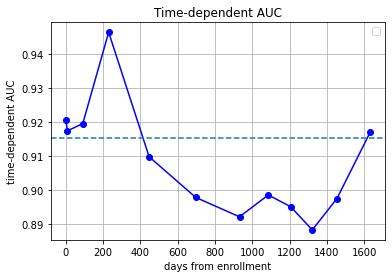

In [10]:
# plot the time dependent auc
times = np.percentile(rea_final['time'], np.linspace(15, 90, 12))
auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, sgb.predict(X_test), times = times)
plt.plot(times, auc, marker="o", color='blue')
plt.title("Time-dependent AUC")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.axhline(mean_auc, linestyle="--")
plt.legend()
plt.grid()

# **Hyperparameters optimization**

In [34]:
# Hyperparameters optimization with optuna

# We use the concordance index as evaluation metric
def scorer(estimator, X, y):
    concordance =  concordance_index_censored([elt[0] for elt in y],[elt[1] for elt in y],estimator.predict(X))[0]
    return concordance

def objective(trial):
    # Define search space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'random_state': 42
    }
    
    # Initialize model with hyperparameters
    model = GradientBoostingSurvivalAnalysis(**params)
    
    def k_fold_cross_validation(model, X, y, k=5):
        """
        Performs k-fold cross-validation for a given model and dataset.

        Parameters:
            model: The machine learning model to evaluate.
            X (numpy.ndarray): The feature matrix.
            y (numpy.ndarray): The target vector.
            k (int): Number of folds for cross-validation.

        Returns:
            float: The average accuracy across all folds.
        """
        n = len(X)
        fold_size = n // k
        scores = []

        for i in range(k):
            # Splitting data into training and validation sets
            validation_X = X[i * fold_size: (i + 1) * fold_size]
            validation_y = y[i * fold_size: (i + 1) * fold_size]
            train_X = np.concatenate([X[:i * fold_size], X[(i + 1) * fold_size:]])
            train_y = np.concatenate([y[:i * fold_size], y[(i + 1) * fold_size:]])

            # Fitting the model
            model.fit(train_X, train_y)

            # Making predictions on the validation set
            y_pred = model.predict(validation_X)

            # Calculating accuracy
            score = scorer(model, validation_X, validation_y)
            scores.append(score)

        # Returning the average accuracy
        return sum(scores) / k
    
    return k_fold_cross_validation(model, X_train, y_train, k=5)

# Create Optuna study object
study = optuna.create_study(direction='maximize')

# Run optimization
study.optimize(objective, n_trials=50)

# Access best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-04-18 10:15:22,445] A new study created in memory with name: no-name-20a7f57b-ba6f-4ee2-8183-ec7c920b1ff4
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Loc

Best Hyperparameters: {'n_estimators': 116, 'learning_rate': 0.08250350043898853, 'subsample': 0.6863594076347115, 'min_samples_split': 18, 'min_samples_leaf': 15, 'max_depth': 5}


output of optuna optimization :

Best Hyperparameters: {'n_estimators': 116, 'learning_rate': 0.08250350043898853, 'subsample': 0.6863594076347115, 'min_samples_split': 18, 'min_samples_leaf': 15, 'max_depth': 5}


In [35]:
# Hyperparameters optimization with a gridsearch approach, we use a gridsearch suggested by the optuna optimization

# Define the gridsearch space
param_grid = {'n_estimators': [231, 232, 233, 234, 235],
              'learning_rate': [0.051, 0.054, 0.06, 0.05774248],
              'subsample': [0.62,0.631222,0.64],
              'max_depth': [3, 4, 2],
              'min_samples_split': [19, 20, 21],
              'min_samples_leaf': [11, 12, 13]}

param_comb = list(product(*(param_grid[param] for param in param_grid.keys())))

# We use the concordance index as evaluation metric
def scorer(estimator, X, y):
    concordance =  concordance_index_censored([elt[0] for elt in y],[elt[1] for elt in y],estimator.predict(X))[0]
    return concordance

# Initialize the model
best_score = 0
best_params = None

for comb in param_comb : 
    # Create model instance with current hyperparameters
    model = GradientBoostingSurvivalAnalysis(n_estimators=comb[0], learning_rate=comb[1], subsample=comb[2], max_depth=comb[3], min_samples_split = comb[4], min_samples_leaf = comb[5], random_state = 42)
    
    def k_fold_cross_validation(model, X, y, k=5):
        """
        Performs k-fold cross-validation for a given model and dataset.

        Parameters:
            model: The machine learning model to evaluate.
            X (numpy.ndarray): The feature matrix.
            y (numpy.ndarray): The target vector.
            k (int): Number of folds for cross-validation.

        Returns:
            float: The average accuracy across all folds.
        """
        n = len(X)
        fold_size = n // k
        scores = []

        for i in range(k):
            # Splitting data into training and validation sets
            validation_X = X[i * fold_size: (i + 1) * fold_size]
            validation_y = y[i * fold_size: (i + 1) * fold_size]
            train_X = np.concatenate([X[:i * fold_size], X[(i + 1) * fold_size:]])
            train_y = np.concatenate([y[:i * fold_size], y[(i + 1) * fold_size:]])

            # Fitting the model
            model.fit(train_X, train_y)

            # Making predictions on the validation set
            y_pred = model.predict(validation_X)

            # Calculating accuracy
            score = scorer(model, validation_X, validation_y)
            scores.append(score)
            
        # Returning the average accuracy
        return sum(scores) / k
    
    if k_fold_cross_validation(model, X_train, y_train, k=5)>best_score:
        best_score = k_fold_cross_validation(model, X_train, y_train, k=5)
        best_params = {'n_estimators':comb[0], 'learning_rate':comb[1], 'subsample':comb[2], 'max_depth':comb[3], 'min_samples_split' : comb[4], 'min_samples_leaf': comb[5], 'random_state' : 42}

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but Gradient

Best Hyperparameters: {'n_estimators': 235, 'learning_rate': 0.051, 'subsample': 0.62, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 13, 'random_state': 42}
Best Score: 0.8707131160221337


c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(


output of gridsearch optimization :

Best Hyperparameters: {'n_estimators': 235, 'learning_rate': 0.051, 'subsample': 0.62, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 13, 'random_state': 42}

Best Score: 0.8707131160221337

In [19]:
best_params = {'n_estimators': 235, 'learning_rate': 0.051, 'subsample': 0.62, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 13, 'random_state': 42}

In [20]:
# Best GradientBoostingSurvivalAnalysis model

best_SGB = GradientBoostingSurvivalAnalysis(**best_params)
best_SGB.fit(X_train, y_train)

# Compute the concordance index

print(f"c_index : {concordance_censored(best_SGB,X_test,y_test)}")

c_index : 0.8881692573402418


# **Optimising hyperparameters according to metrics**

In [68]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)

cv_param_grid = {
    "estimator__max_depth": np.arange(1, 10, dtype=int),
}

In [75]:
gcv_cindex = GridSearchCV(
    as_concordance_index_ipcw_scorer(best_SGB, tau=times[-1]),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(X_train, y_train)

In [77]:
gcv_iauc = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(best_SGB, times=times),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(X_train, y_train)

In [78]:
gcv_ibs = GridSearchCV(
    as_integrated_brier_score_scorer(best_SGB, times=times),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(X_train, y_train)

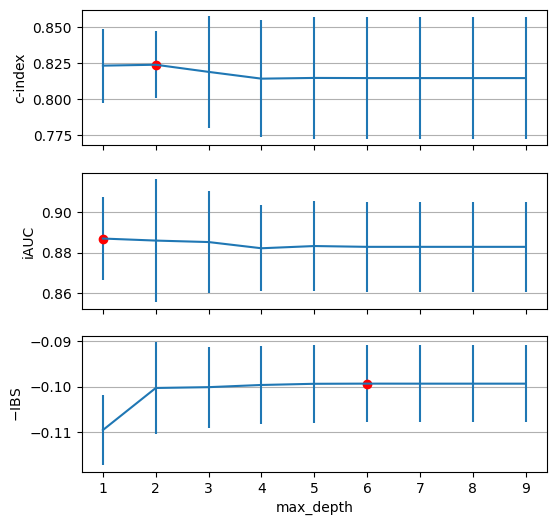

In [79]:
def plot_grid_search_results(gcv, ax, name):
    ax.errorbar(
        x=gcv.cv_results_["param_estimator__max_depth"].filled(),
        y=gcv.cv_results_["mean_test_score"],
        yerr=gcv.cv_results_["std_test_score"],
    )
    ax.plot(
        gcv.best_params_["estimator__max_depth"],
        gcv.best_score_,
        "ro",
    )
    ax.set_ylabel(name)
    ax.yaxis.grid(True)


_, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
axs[-1].set_xlabel("max_depth")

plot_grid_search_results(gcv_cindex, axs[0], "c-index")
plot_grid_search_results(gcv_iauc, axs[1], "iAUC")
plot_grid_search_results(gcv_ibs, axs[2], "$-$IBS")

# **Interpretability methods**

# RVI

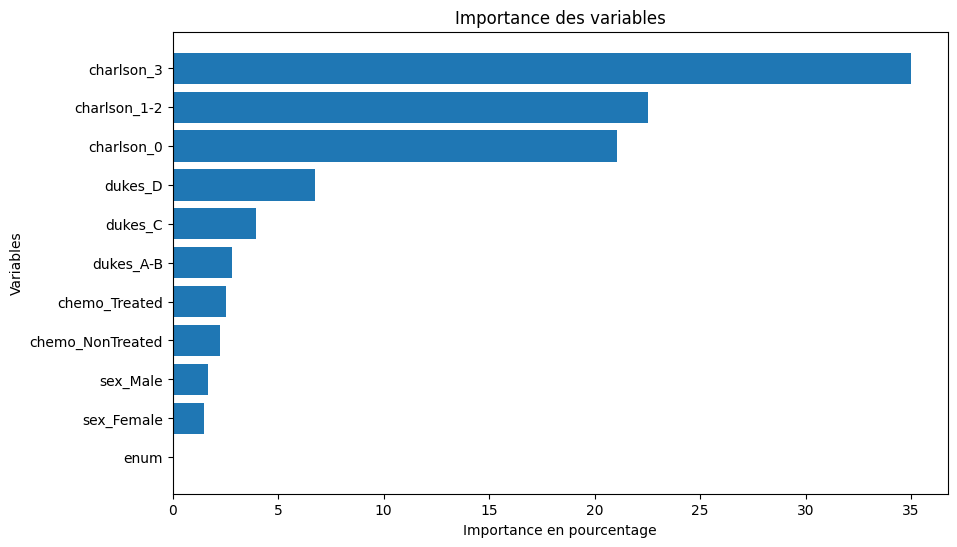

In [40]:
feature_importances = best_SGB.feature_importances_

total_importance = np.sum(feature_importances)
importances_percentage = (feature_importances / total_importance) * 100
importances_percentage.sort()
variable_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances_percentage)), importances_percentage, tick_label=variable_names)
plt.xlabel('Importance en pourcentage')
plt.ylabel('Variables')
plt.title('Importance des variables')
plt.show()

# SurvLIME

In [23]:
# define explainer for the best model
explainer_gb = SurvLimeExplainer(
    training_features=X_train,
    training_events=[tp[0] for tp in y_train],
    training_times=[tp[1] for tp in y_train],
    model_output_times=best_SGB.event_times_,
    random_state=42,
)


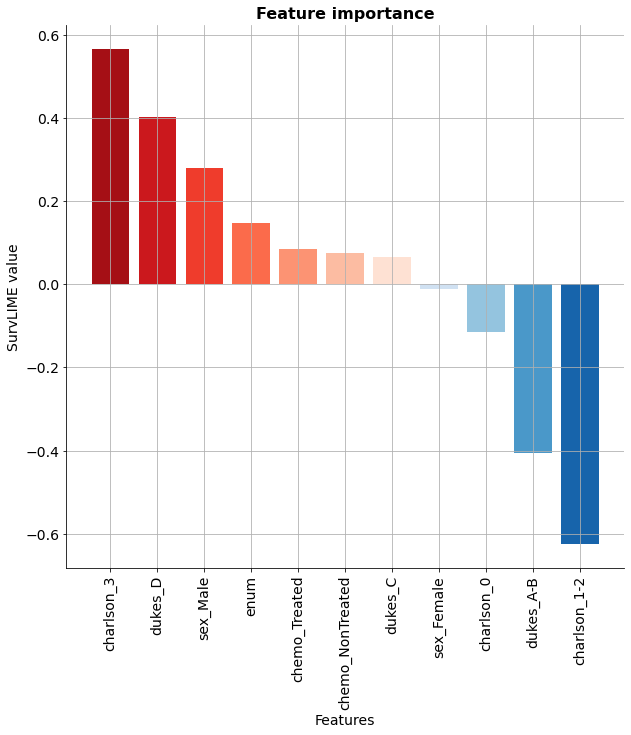

In [33]:
# plot feature importance
explainer_gb.plot_weights()

In [28]:
# select instance to explain
instance_index = 0

# explain one instance
b_gb = explainer_gb.explain_instance(
    data_row = X_test.iloc[instance_index].values,
    predict_fn=best_SGB.predict_cumulative_hazard_function,
    num_samples=1000,
    verbose=False,
)



In [36]:
# create a dictionary that maps the feature names to lime feature coefficient

feature_names = X_train.columns
feature_dict = {}
for i in range(len(feature_names)):
    feature_dict[feature_names[i]] = b_gb[i]

feature_dict

{'enum': 0.14611440080264496,
 'sex_Female': -0.010663091602880058,
 'sex_Male': 0.2785437315919583,
 'chemo_NonTreated': 0.07504503387207682,
 'chemo_Treated': 0.0844941542618211,
 'dukes_A-B': -0.40701998201361406,
 'dukes_C': 0.06569907506283017,
 'dukes_D': 0.401836194820064,
 'charlson_0': -0.1155686908366406,
 'charlson_1-2': -0.6237902191803436,
 'charlson_3': 0.5645333948986223}

# SHAP

In [54]:
# Let's use shap method to interpret this model, since the output of a SSVM is a risk score, we can use classical shap method to interpret it

# use Tree Explainer SHAP to explain test set predictions
explainer = shap.Explainer(best_SGB.predict, X_train)
shap_values = explainer.shap_values(X_test)

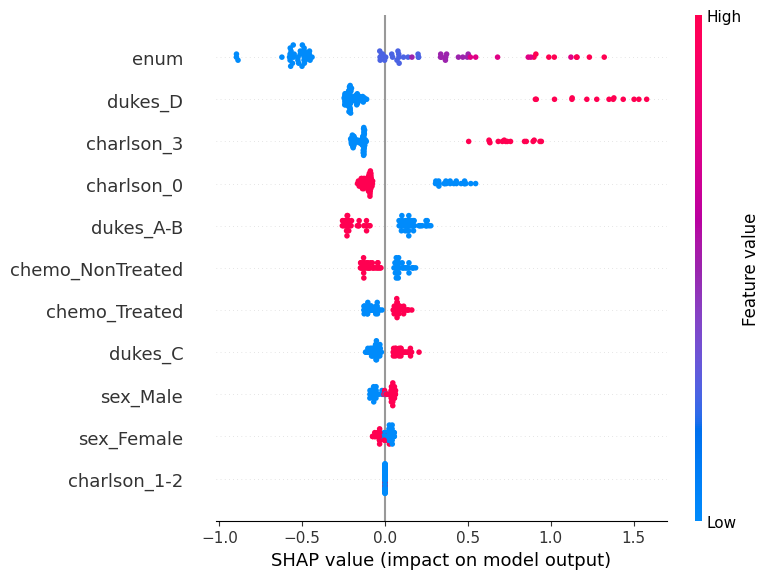

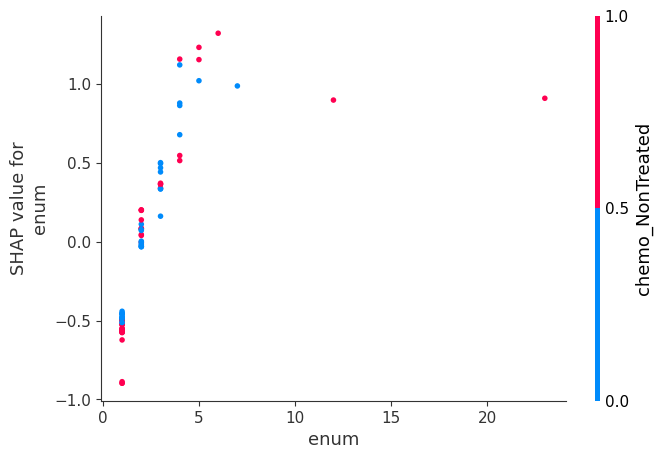

In [61]:
# summary plot of shap values
shap.summary_plot(shap_values,X_test)

# dependence plot of shap values
shap.dependence_plot("enum", shap_values, X_test)